Name: Jonathan Park <br>
Date: 2022.04.03

# Project Shappify: Text Pre-processing, Language Detection and Vectorization Part 2
***

## Introduction

Using the output of the reviews dataframe from Part 1, the steps in this notebook involves iterative text pre-processing of the reviews coupled with a pre-trained hierarchical classifier for language detection and isolating English language reviews. These processes are implemented in order to minimize the noise in the dataset and in preparation for implementing models in Part 3 and Part 4 of the Jupyter Notebooks.

### Standard Data Formats: Document-Term Matrix

In order to complete the data analyses in these upcoming notebooks, I will be using scikit-learn's CountVectorizer to break down a document's (i.e., in this context, a document or doc refers to each individual review text) sentence(s) into individual words or tokens. This process is called tokenization. The frequency of appearance of an individual word or token for a doc is then recorded along the row and the unique token is represented as a feature or column. This process results in a Document-Term Matrix (DTM) that can then be used in other analyses.

Each individual word or token or unigram may be synonymously used throughout this notebook. However, it is also possible to break down sentences by pairs or triplets of words, called bigrams or trigrams, respectively. Bigrams will be briefly explored throughout the EDA process.

<!-- In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc. -->

### Import Packages

In [1]:
# Array and dataframe manipulation libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Visual progress bar library
from tqdm import tqdm
tqdm.pandas()

# Text pre-processing packages
import re
import string
import contractions

# Language detection library
import fasttext

# Natural language toolkit library
import nltk
from nltk.tokenize import word_tokenize # Tokenize text
from nltk.tokenize.treebank import TreebankWordDetokenizer # Detokenize text
from nltk.stem import WordNetLemmatizer # Lemmatizer
from nltk.corpus import wordnet # POS Tagging

# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer

### Defining Functions

I will define a function that will plot the top 20 most frequent tokens.

In [2]:
def plot_most_frequent(df, n_gram, top=20):
    
    """
    Creates a bar graph of the top 20 tokens.
    Specify the n_gram range utilized
    for display in the graph's title.
    
    Parameters
    ----------
    df : Dataframe of reviews.
    n_gram : Text for inputting into the graph title (e.g., unigram, bigram).
    top : The top 20 (default) tokens will be depicted.

    """

    fig, ax = plt.subplots(figsize=(0.75 * top, 5))
    
    ############# Bar Graph #############
    df.sort_values(by="count", ascending=False).\
                   head(top).\
                   plot(kind="bar",
                        rot=45,
                        ax=ax,
                        legend = None)

    # Set title and axes labels
    plt.title(f"Most frequent {n_gram}", size=24)
    plt.ylabel("Total Reviews Count")
    
    # Remove top and right borders
    sns.despine()
    
    plt.show()

### Import Data

Please make sure the directory has been changed to match your folder destination.

In [3]:
# Import dataset
reviews_df = pd.read_pickle('reviews_df_part_1.pkl')

###  Overview of Data

I will check the top 5 rows and bottom 5 rows of the dataframe to remind myself of what the data looks like.

In [4]:
# Print the first 5 rows
reviews_df.head()

,app_name,author,rating,review_date,review_text,helpful_count,dev_reply_text,dev_reply_date,is_review_good
0,Instant Search +,Consuela,5,2020-08-06,Great and super fast customer service! Highly ...,0,NaN,NaT,1
1,Instant Search +,L'Atelier Global,5,2020-08-04,"Still setting up my store, and after initially...",0,NaN,NaT,1
2,Instant Search +,city'super E-Shop,5,2020-08-04,"This is an excellent search app, which they ha...",0,NaN,NaT,1
3,Instant Search +,PortableHandwashing.com,5,2020-07-30,"A+, great great great customer service! thanks...",0,NaN,NaT,1
4,Instant Search +,ICCTUNING,5,2020-07-28,"I'm begginig to use this app, the search engin...",0,NaN,NaT,1


In [5]:
# Similarly, print the last 5 rows to identify if any 
# non-data related content was tacked on at the bottom (e.g., comments)
reviews_df.tail()

,app_name,author,rating,review_date,review_text,helpful_count,dev_reply_text,dev_reply_date,is_review_good
446968,COD Order Confirmation,Feltin,5,2018-03-22,Very very well explained tutorial. Seems very ...,0,NaN,NaT,1
446969,COD Order Confirmation,Srstore09,5,2018-01-23,Finally we have an App for for CoD Confirmatio...,0,NaN,NaT,1
446970,COD Order Confirmation,Eshop Fashion,5,2018-01-05,"Useful, App help us to reduce cost & time. hig...",0,NaN,NaT,1
446971,COD Order Confirmation,Arabicworld,1,2017-06-15,Do not purchase this application!\nit's like s...,0,NaN,NaT,0
446972,COD Order Confirmation,Ethnicyug,5,2016-01-06,​​A must​ have​ app for those having e-stores ...,0,NaN,NaT,1


In [6]:
# Quick summary of dataframe's columns, data type, and non-null counts
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446973 entries, 0 to 446972
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        446973 non-null  object        
 1   author          446973 non-null  object        
 2   rating          446973 non-null  int64         
 3   review_date     446973 non-null  datetime64[ns]
 4   review_text     446973 non-null  object        
 5   helpful_count   446973 non-null  int64         
 6   dev_reply_text  47542 non-null   object        
 7   dev_reply_date  47542 non-null   datetime64[ns]
 8   is_review_good  446973 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(2), object(4)
memory usage: 32.4+ MB


There are currently 8 columns in the dataframe (excluding the index). I will drop the `author`, `rating`, and `helpful_count` columns since I will not be using them in the downstream analysis.

In [7]:
# Drop columns from dataframe
reviews_df.drop(columns = ['author', 'rating', 'helpful_count'], inplace = True)

Confirm that the columns have been dropped.

In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446973 entries, 0 to 446972
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        446973 non-null  object        
 1   review_date     446973 non-null  datetime64[ns]
 2   review_text     446973 non-null  object        
 3   dev_reply_text  47542 non-null   object        
 4   dev_reply_date  47542 non-null   datetime64[ns]
 5   is_review_good  446973 non-null  int32         
dtypes: datetime64[ns](2), int32(1), object(3)
memory usage: 22.2+ MB


The total columns in the dataframe decreased to 5 columns, indicating successful dropping of columns.

#### What is the vocabulary size prior to any text pre-processing?

For exploratory purposes, I will obtain the size of the vocabulary from the Document-Term sparse matrix created by the CountVectorizer function from the Sklearn library.

In [9]:
# Instantiate Countvectorizer with ngrams = 1 default
cv_base = CountVectorizer()

# Fit and transform the review text column
cv_base_results = cv_base.fit_transform(reviews_df['review_text'])

In [10]:
# Print the results of the vectorized results
cv_base_results

<446973x104750 sparse matrix of type '<class 'numpy.int64'>'
	with 11228604 stored elements in Compressed Sparse Row format>

The current vocabulary size is 104,750 without text pre-processing. Let's see how this changes as we go through the different text pre-processing steps. This is analagous to dimensionality reduction, which will be important for the future modeling in Parts 3 and 4 of the Jupyter Notebooks.

## Text Pre-Processing Round 1

The initial text pre-processing for round 1 will be to first remove the line breaks (e.g., \n) that can appear within the review texts. This step is implemented to also enable a first pass of the review texts into the pre-trained hierarchical classifier for multi-language detection. Additional details will be outlined in subsequent sections regarding the language detection model.

First define a function that will implement the round 1 of text pre-processing below.

In [11]:
def clean_review_round_1(review_text):
    
    """
    Remove nonsensical text such as 
    \n (i.e., line breaks).
    
    Parameters
    ----------
    review_text : Array of review texts.

    Returns
    -------
    review_text : Array of review texts with nonsensical text removed.
    
    """

    assert isinstance(review_text, str), 'Input string arguments only'

    # Subsitute newline characters with space
    review_text = re.sub('\n', ' ', review_text)
    
    return review_text

I will now create a copy of the `reviews_df` dataframe into a new variable `reviews_df_clean_1`, which represents the dataframe that will contain results from the first round of pre-processing.

In [12]:
# Create a new variable
reviews_df_clean_1 = reviews_df.copy()

Apply the text pre-processing to `reviews_df_clean_1`.

In [13]:
reviews_df_clean_1['review_text'] = reviews_df_clean_1['review_text'].progress_apply(lambda x: clean_review_round_1(x))

100%|██████████| 446973/446973 [00:01<00:00, 377528.08it/s]


### Language Detection Round 1

Throughout the data wrangling phase in Part 1, instances of reviews being posted in languages other than English were observed. For this reason, a language detection step is integrated to identify what other languages are present and to separate out English language reviews for downstream analysis.

I am using the open-source pre-trained model made available by [fasttext](https://fasttext.cc/docs/en/language-identification.html) (formerly fastText), which was first created by researchers from the [Facebook AI group](https://research.facebook.com/blog/2016/08/fasttext/). It is capable of recognizing 176 different languages and provides ISO language codes for the identified language. This open-source library was chosen for the main reason of optimal speed and performance. For instance, an interesting [article](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c) describes the comparison in speed and accuracy of language detection of the fasttext model in comparison to other methods (e.g., SpaCy). In addition, my attempt of implementing SpaCy's language detection took $\approx$ 3-5 hours for the model to complete. Given multiple instances of language detection in this notebook, that method was not feasible at this time. For those reasons, fasttext was implemented.

I will first load and instantiate the fasttext pre-trained model. The pre-trained model can be found [here](https://fasttext.cc/docs/en/language-identification.html).

Implementation code for fasttext was adapted from the following:

- [Source 1](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c)

In [14]:
# Load pre-trained hierarchical model downloaded from fasttext
path_to_model = 'lid.176.bin'
ft_model = fasttext.load_model(path_to_model)

I will now define a function that will use the fasttext model to classify the language of a review's text and extract the 2-3 letter ISO language code from the results.

In [15]:
def lang_detect(review_text):
    
    """    
    Using fasttext's pre-trained hierarchical classifer,
    multi-language detection is implemented. Specified output 
    are 2-3 letter ISO language codes.
    
    Parameters
    ----------
    review_text : Array of review texts.

    Returns
    -------
    lang_result : The ISO language code.
    
    """

    
    assert isinstance(review_text, str), 'Input string arguments only'

    
    # Extract the ISO language code
    lang_result = [p.replace('__label__', '') for p in ft_model.predict(review_text)[0]][0]
    
    return lang_result

I will now apply the function to the review texts. This step is relatively quick, taking approximately 20 seconds to classify $\approx$ 450,000 reviews. A new column is created in the dataframe, called `lang_iso`, representing the ISO language code output from the above function.

In [16]:
reviews_df_clean_1['lang_iso'] = reviews_df_clean_1['review_text'].progress_apply(lambda x: lang_detect(x))

100%|██████████| 446973/446973 [00:17<00:00, 25518.55it/s]


#### Save English Language Reviews - Round 1

I will now separate all the review texts classified as `en` for English, into a new variable titled `reviews_df_clean_1_en`.

In [17]:
# Create new dataframe with only the English language reviews
reviews_df_clean_1_en = reviews_df_clean_1[reviews_df_clean_1['lang_iso'] == 'en']

Take a quick glimpse of the new dataframe.

In [18]:
# Print first 5 rows
reviews_df_clean_1_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,Great and super fast customer service! Highly ...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,"Still setting up my store, and after initially...",NaN,NaT,1,en
2,Instant Search +,2020-08-04,"This is an excellent search app, which they ha...",NaN,NaT,1,en
3,Instant Search +,2020-07-30,"A+, great great great customer service! thanks...",NaN,NaT,1,en
4,Instant Search +,2020-07-28,"I'm begginig to use this app, the search engin...",NaN,NaT,1,en


Check the size of the new dataframe.

In [19]:
# Shape of the dataframe
[nrows, ncols] = reviews_df_clean_1_en.shape
print(f"The dataframe shape we are working with has {nrows} rows and {ncols} columns.")
print(f"A total of {len(reviews_df_clean_1) - len(reviews_df_clean_1_en)} rows were removed.")

The dataframe shape we are working with has 426568 rows and 7 columns.
A total of 20405 rows were removed.


In [20]:
reviews_df_clean_1_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426568 entries, 0 to 446972
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        426568 non-null  object        
 1   review_date     426568 non-null  datetime64[ns]
 2   review_text     426568 non-null  object        
 3   dev_reply_text  45280 non-null   object        
 4   dev_reply_date  45280 non-null   datetime64[ns]
 5   is_review_good  426568 non-null  int32         
 6   lang_iso        426568 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 24.4+ MB


Based on the initial pass of the language detection, we can see that $\approx$ 20,000 reviews were in different languages. I will conduct additional text pre-processing and see if these numbers/proportions change. Upon completing the final text pre-processing, a deeper dive into the languages will be explored.

I will now save the English-only reviews for Part 3 in the Jupyter Notebook series.

Save the results into a .pkl file. If it's commented out, the file has already been saved and loaded in one 1-2 cells right below this one.

In [21]:
# # Save English-only reviews as pickle file
# reviews_df_clean_1_en.to_pickle("reviews_df_clean_1_en_part_2.pkl")

In [22]:
# Load the saved pickle file from a previous implementation
reviews_df_clean_1_en = pd.read_pickle('reviews_df_clean_1_en_part_2.pkl')

#### What is the size of the vocabulary for English-only reviews after round 1 of text pre-processing?

In [23]:
# Instantiate Countvectorizer with ngrams = 1 default
cv_round_1 = CountVectorizer()

# Fit and transform the review text column
cv_round_1_results = cv_round_1.fit_transform(reviews_df_clean_1_en['review_text'])

In [24]:
cv_round_1_results

<426568x73637 sparse matrix of type '<class 'numpy.int64'>'
	with 10889991 stored elements in Compressed Sparse Row format>

After 1 round of text pre-processing and separating out English-language reviews, the vocabulary decreased to 73,637. The previous vocabulary size was 104,750 without text pre-processing.

## Text Pre-Processing Round 2

I will now implement additional text pre-processing and observe if that changes the ability for the language detection pre-trained classifier to filter between English language and multi-language reviews.

The different text pre-processing steps were motivated and adapted from the following Youtube NLP tutorial series by dashofdata and corresponding GitHub: 

- Source 1: [Dashofdata Youtube Tutorials](https://www.youtube.com/watch?v=5BVebXXb2o4)
- Source 2: [Dashofdata GitHub](https://github.com/adashofdata/nlp-in-python-tutorial)

I have defined a function that will perform the following for text pre-processing round 2:

- lowercase all text
- removes URL text links
- expand contractions
- substitute hyphens with whitespace
- substitute punctuation marks with whitespace
- substitute words with numbers inside (i.e., sandwiched between ascii characters) with whitespace
- substitute repeating characters > 2 to a maximum of 2 characters
- substitute any sequence of whitespace with a single whitespace

In [25]:
def clean_review_round_2(review_text):
    
    """
    Makes review text lowercase, removes URL text links, expands contractions,
    removes punctuation marks, removes words containing numbers,
    removes repeating characters to a maximum of 2, and
    replaces multiple sequenced whitespaces to a single whitespace.
    
    Parameters
    ----------
    review_text : Array of review texts.

    Returns
    -------
    review_text : Array of review texts with round 1 of text pre-processing applied.
    
    """

    
    assert isinstance(review_text, str), 'Input string arguments only'
    
    # Make review text all lowercase
    review_text = review_text.lower()
    
    # Replace URL links with empty string
    # https://stackoverflow.com/questions/10475027/extracting-url-link-using-regular-expression-re-string-matching-python
    # Text with www. and trailing characters that are not whitespace are
    # matched and replaced with empty string
    review_text = re.sub("www.[^\s]+", "", review_text)

    # Expand out contractions
    review_text = contractions.fix(review_text)
    
    # String.punctuation gives string of all sets of punctuation marks
    # take punctuation marks and "escape" any special metacharacters
    # feed punctuation marks into where %s is
    # square brackets will take punctuation marks one at a time
    # substitute/remove punctuation mark with empty string
    review_text = re.sub('[-]', ' ', review_text) # remove hyphens so that I do not have to worry about chances where there is more than 2 repeating characters (e.g., skull-like)
    review_text = re.sub('[%s]' % re.escape(string.punctuation), '', review_text)

    # Take the digit inside a word, where \w represents any repeating ascii character
    # and subsitute with nothing (i.e., remove)
    review_text = re.sub('\w*\d\w*', ' ', review_text)
    
    # Replace repeating characters in words with a maximum of 2 
    review_text = re.sub("(.)\\1{2,}", "\\1\\1", review_text)
    
    # Remove multiple whitespaces
    review_text = re.sub(' +', ' ', review_text)
    
    return review_text

I will now create a copy of the `reviews_df_clean_1` dataframe into a new variable `reviews_df_clean_2`, which represents the dataframe that will go through the second round of pre-processing.

In [26]:
reviews_df_clean_2 = reviews_df_clean_1.copy()

Quick glimpse of the first 5 rows prior to pre-processing the dataframe.

In [27]:
reviews_df_clean_2.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,Great and super fast customer service! Highly ...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,"Still setting up my store, and after initially...",NaN,NaT,1,en
2,Instant Search +,2020-08-04,"This is an excellent search app, which they ha...",NaN,NaT,1,en
3,Instant Search +,2020-07-30,"A+, great great great customer service! thanks...",NaN,NaT,1,en
4,Instant Search +,2020-07-28,"I'm begginig to use this app, the search engin...",NaN,NaT,1,en


Apply the text pre-processing to `reviews_df_clean_2`.

In [28]:
reviews_df_clean_2['review_text'] = reviews_df_clean_2['review_text'].progress_apply(lambda x: clean_review_round_2(x))

100%|██████████| 446973/446973 [00:29<00:00, 15126.71it/s]


Quick glimpse of the first 5 rows of the processed dataframe.

In [29]:
reviews_df_clean_2.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,great and super fast customer service highly c...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,still setting up my store and after initially ...,NaN,NaT,1,en
2,Instant Search +,2020-08-04,this is an excellent search app which they hav...,NaN,NaT,1,en
3,Instant Search +,2020-07-30,a great great great customer service thanks to...,NaN,NaT,1,en
4,Instant Search +,2020-07-28,i am begginig to use this app the search engin...,NaN,NaT,1,en


We can see that the text pre-processing steps was applied to the `review_text`.

In [30]:
reviews_df_clean_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446973 entries, 0 to 446972
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        446973 non-null  object        
 1   review_date     446973 non-null  datetime64[ns]
 2   review_text     446973 non-null  object        
 3   dev_reply_text  47542 non-null   object        
 4   dev_reply_date  47542 non-null   datetime64[ns]
 5   is_review_good  446973 non-null  int32         
 6   lang_iso        446973 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 25.6+ MB


### Post Text Pre-Processing Data Removal

Throughout the cleaning and pre-processing phase, I noticed a few examples of reviews that contain nonsensical text that would result in empty texts after text pre-processing. Below are some examples. As a result, an extra step is incorporated to remove reviews that do not contain any text.

Example 1 of a review prior to any text pre-processing.

In [31]:
# Example review prior to any pre-processing
reviews_df.loc[4_508,'review_text']

'.............................................................................................................................................................'

Example 1 post text pre-processing. Notice that it is an empty string.

In [32]:
# Example review post pre-processing
reviews_df_clean_2.loc[4_508,'review_text']

''

Example 2 of a review prior to any text pre-processing.

In [33]:
reviews_df.loc[139_498,'review_text']

'///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////'

Example 2 post text pre-processing. Notice that it is an empty string.

In [34]:
reviews_df_clean_2.loc[139_498,'review_text']

''

The total count of reviews that were empty after the first 2 rounds of text pre-processing is counted below.

In [35]:
reviews_df_clean_2[reviews_df_clean_2['review_text'] == ''].count()

app_name          111
review_date       111
review_text       111
dev_reply_text      9
dev_reply_date      9
is_review_good    111
lang_iso          111
dtype: int64

We can see that 111 rows of data now contain an empty string. I will create an index to remove the empty review text string from the dataframe.

In [36]:
# Index for rows to drop/remove
drop_index = reviews_df_clean_2[reviews_df_clean_2['review_text'] == ''].index

In [37]:
# Drop the rows from dataframe
reviews_df_clean_2.drop(drop_index, inplace = True, axis = 0)

We can see that the count of empty strings are now removed.

In [38]:
reviews_df_clean_2[reviews_df_clean_2['review_text'] == ''].count()

app_name          0
review_date       0
review_text       0
dev_reply_text    0
dev_reply_date    0
is_review_good    0
lang_iso          0
dtype: int64

I also have a total count of reviews that were empty and contained only whitespace after the first 2 rounds of text pre-processing.

Example 3 of a review prior to any text pre-processing.

In [39]:
reviews_df.loc[122_436,'review_text']

'1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'

Example 3 post text pre-processing. Notice that it is a string with empty whitespace.

In [40]:
reviews_df_clean_2.loc[122_436,'review_text']

' '

In [41]:
reviews_df_clean_2[reviews_df_clean_2['review_text'] == ' '].count()

app_name          224
review_date       224
review_text       224
dev_reply_text     15
dev_reply_date     15
is_review_good    224
lang_iso          224
dtype: int64

We can see that 224 rows of data contain an empty whitespace. We will create an index to remove the empty rows from the dataframe.

In [42]:
# Index for rows to drop/remove
drop_index = reviews_df_clean_2[reviews_df_clean_2['review_text'] == ' '].index

In [43]:
# Drop the rows from dataframe
reviews_df_clean_2.drop(drop_index, inplace = True, axis = 0)

We can see that the count of empty strings that contained only whitespace are now removed.

In [44]:
reviews_df_clean_2[reviews_df_clean_2['review_text'] == ' '].count()

app_name          0
review_date       0
review_text       0
dev_reply_text    0
dev_reply_date    0
is_review_good    0
lang_iso          0
dtype: int64

In [45]:
# Shape of the NEW dataframe
[nrows_new, ncols_new] = reviews_df_clean_2.shape
print(f"The updated dataframe shape we are working with now has {nrows_new} rows and {ncols_new} columns")

The updated dataframe shape we are working with now has 446638 rows and 7 columns


### Language Detection Round 2

I will now apply the function to `review_df_clean_2` dataframe. This step is again, relatively quick.

In [46]:
# Apply language detect pre-trained model that was previously instantiated to the dataframe
reviews_df_clean_2['lang_iso'] = reviews_df_clean_2['review_text'].progress_apply(lambda x: lang_detect(x))

100%|██████████| 446638/446638 [00:17<00:00, 25607.60it/s]


#### Save English Language Reviews - Round 2

I will now separate all the review texts classified as `en` for English, into a new variable titled `reviews_df_clean_2_en`.

In [47]:
# Create new dataframe with only the English language reviews after round 2 of text pre-processing
reviews_df_clean_2_en = reviews_df_clean_2[reviews_df_clean_2['lang_iso'] == 'en']

Take a quick glimpse of the new dataframe.

In [48]:
reviews_df_clean_2_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,great and super fast customer service highly c...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,still setting up my store and after initially ...,NaN,NaT,1,en
2,Instant Search +,2020-08-04,this is an excellent search app which they hav...,NaN,NaT,1,en
3,Instant Search +,2020-07-30,a great great great customer service thanks to...,NaN,NaT,1,en
4,Instant Search +,2020-07-28,i am begginig to use this app the search engin...,NaN,NaT,1,en


Check the size of the new dataframe.

In [49]:
# Shape of the dataframe
[nrows, ncols] = reviews_df_clean_2_en.shape
print(f"The dataframe shape we are working with has {nrows} rows and {ncols} columns.")
print(f"A total of {len(reviews_df_clean_2) - len(reviews_df_clean_2_en)} rows were removed.")

The dataframe shape we are working with has 427298 rows and 7 columns.
A total of 19340 rows were removed.


In [50]:
reviews_df_clean_2_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427298 entries, 0 to 446972
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        427298 non-null  object        
 1   review_date     427298 non-null  datetime64[ns]
 2   review_text     427298 non-null  object        
 3   dev_reply_text  45305 non-null   object        
 4   dev_reply_date  45305 non-null   datetime64[ns]
 5   is_review_good  427298 non-null  int32         
 6   lang_iso        427298 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 24.5+ MB


Check the distribution of positive and negative reviews in the English-only reviews extracted after 2 rounds of text pre-processing.

In [51]:
reviews_df_clean_2_en['is_review_good'].value_counts(normalize=True)

1    0.930187
0    0.069813
Name: is_review_good, dtype: float64

The proportion of positive and negative reviews have remained relatively similar to what was observed prior to any text pre-processing and removal of multi-language reviews.

I will now save the English-only reviews for Part 3 in the Jupyter Notebook series.

Save the results into a .pkl file. If it's commented out, the file has already been saved and loaded in one 1-2 cells right below this one.

In [52]:
# # Save English-only reviews as pickle file
# reviews_df_clean_2_en.to_pickle("reviews_df_clean_2_en_part_2.pkl")

In [53]:
# Load the pickle file from a previous implementation
reviews_df_clean_2_en = pd.read_pickle('reviews_df_clean_2_en_part_2.pkl')

Based on the language detection after 2 rounds of text pre-processing, we can see that $\approx$ 19,000 reviews were in different languages. An extra 1,000 English language reviews were extracted after two rounds of text pre-processing. I will compare and contrast the differences in the extracted language reviews observed after round 1 of text pre-processing versus round 2 of text pre-processing.

#### What is the size of the vocabulary for English-only reviews after round 2 of text pre-processing?

In [54]:
# Instantiate Countvectorizer with ngrams = 1
cv_round_2 = CountVectorizer()

# Fit and transform the review text column
cv_round_2_results = cv_round_2.fit_transform(reviews_df_clean_2_en['review_text'])

In [55]:
cv_round_2_results

<427298x81035 sparse matrix of type '<class 'numpy.int64'>'
	with 10854151 stored elements in Compressed Sparse Row format>

After the 2nd round, the vocabulary increased to 81,035. This is in contrast to round 1's English-only reviews vocabulary of 73,637. This may be due to the preservation of additional English-language reviews.

## Comparing Language Detection Results from Round 1 versus Round 2

I will merge the two dataframes of English-only language reviews that were retrieved during Rounds 1 and 2 of language detection implementation to observe what the differences were.

Inspiration on the code to compare two unequal sized dataframes were derived from this [stack overflow page](https://stackoverflow.com/questions/60166307/compare-columns-in-pandas-between-two-unequal-size-dataframes-for-condition-chec).

In [56]:
# Merge the dataframes using an outer join
df_merged = reviews_df_clean_1_en.merge(reviews_df_clean_2_en, how='outer', left_index=True, right_index=True)

I will now take a look at the English language reviews that were detected during Round 2 but not in Round 1.

The columns with suffix "x" is the dataframe that underwent only Round 1 of text pre-processing. Columns with suffix "y" is the dataframe that went through Round 1 and 2 of text pre-processing.

Note: Make sure to scroll to the right of the dataframe to see the data.

In [57]:
df_merged[df_merged['lang_iso_x'].isna()].head(40)

,app_name_x,review_date_x,review_text_x,dev_reply_text_x,dev_reply_date_x,is_review_good_x,lang_iso_x,app_name_y,review_date_y,review_text_y,dev_reply_text_y,dev_reply_date_y,is_review_good_y,lang_iso_y
501,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Instant Search +,2016-08-15,nice job from,NaN,NaT,1.0,en
682,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Sticky Add To Cart BOOSTER PRO,2020-08-21,wow very good thanks good,NaN,NaT,1.0,en
809,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Sticky Add To Cart BOOSTER PRO,2020-02-03,goodd,NaN,NaT,1.0,en
934,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Sticky Add To Cart BOOSTER PRO,2019-09-01,really good,"Hi Zuluzula, thank you for your review 🙏. Glad...",2019-09-03,1.0,en
1045,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Sticky Add To Cart BOOSTER PRO,2019-05-16,best app cool,NaN,NaT,1.0,en
1048,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Sticky Add To Cart BOOSTER PRO,2019-05-13,so far so good i just got it i hope it does go...,NaN,NaT,1.0,en
1290,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Sticky Add To Cart BOOSTER PRO,2018-08-20,good,NaN,NaT,1.0,en
1473,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Sticky Add To Cart BOOSTER PRO,2017-10-17,cool,NaN,NaT,1.0,en
2252,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Countdown Timer | Cart Timer,2019-03-24,good appdffgffdffdd,NaN,NaT,1.0,en
2253,NaN,NaT,NaN,NaN,NaT,NaN,NaN,Countdown Timer | Cart Timer,2019-03-10,real goodd,NaN,NaT,1.0,en


I can see that the English language reviews detected in Round 2 are correctly identified as English-language reviews. However, I also see that some of the reviews that were detected contain nonsensical text that provide no meaning. These nonsensical texts can be added to a custom stop-word list.

Examples of stop-words to add are:

- appdffgffdffdd
- mknjpqdsfdsfcsdrdsfcdsfsdscfdsff

I will now take a look at the English language reviews that were detected during Round 1 but not in Round 2, if any.

In [58]:
df_merged[df_merged['lang_iso_y'].isna()]

,app_name_x,review_date_x,review_text_x,dev_reply_text_x,dev_reply_date_x,is_review_good_x,lang_iso_x,app_name_y,review_date_y,review_text_y,dev_reply_text_y,dev_reply_date_y,is_review_good_y,lang_iso_y
747,Sticky Add To Cart BOOSTER PRO,2020-04-30,ME ENCANTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
754,Sticky Add To Cart BOOSTER PRO,2020-04-07,como faço pra a pessoa excluir algo do carrinh...,NaN,NaT,0.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
755,Sticky Add To Cart BOOSTER PRO,2020-04-07,"GREATSF,DV,LKdnvNsvnOsdviodsoijvKyxjVKLdkV oi...",NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
998,Sticky Add To Cart BOOSTER PRO,2019-07-06,TRES BONNE APPLI !!,NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
1137,Sticky Add To Cart BOOSTER PRO,2019-02-25,gggggggggggggggggggggggggggggggggggggggggggggg...,NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440944,Printful: Print‑on‑Demand,2018-12-17,SUPER APPLICATION JE RECOMMANDE VIVEMENT PROD...,NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
442988,SEO Images King,2020-06-13,Application au top! service client fantastique...,NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
443454,SEO Images King,2018-04-09,Test Test Test Test Test Test Test Test Test T...,NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN
444674,Promotion Popup by Secomapp,2019-03-11,WWW.JEWELR-STYLE.COM,NaN,NaT,1.0,en,NaN,NaT,NaN,NaN,NaT,NaN,NaN


I see that the English language reviews detected in Round 1 were missed as English-language reviews in Round 2. However, I also see reviews classified as English but were not, indicating some improvement with Round 2 of text pre-processing. In addition, some of the reviews in Round 1 contain nonsensical text that provide no meaning.

Examples of additional stop-words to add are:

- WWW.JEWELR-STYLE.COM

Based on these observations, an additional regular expression to extract any strings that start with "www." can be implemented. This was implemented a posteriori in the text pre-processing round 2.

Given that a second round of text pre-processing resulted in more English language reviews being detected, despite some possible false positives, the English language reviews from Round 2 will be utilized for further analyses. Opportunities for further analysis of the misclassification in multi-language reviews can be revisited in this section in the future.

## Text Pre-Processing Round 3

For the last round of text pre-processing, text normalization will be implemented through lemmatization of the nouns, verbs, adverbs, and adjectives within the review text. Although stemming is another technique of text normalization, such as the Porter2 or Snowball Stemmer through NLTK's library, stemming will not be used at this time due to the word being stemmed potentially not returning to its' canonical form (e.g., leaves == leav instead of leaf).

An example of lemmatization is the following:

- Make 'beautifully' into 'beautiful' as they're the same root word (lemmatization)

Different Part-Of-Speech (POS) implementations were explored prior to tokenization and lemmatization for this section. For instance, SpaCy consists of POS tagging than can be extracted from creating doc objects using one of their pre-trained models. However, due to the implementation duration ranging $\approx$ 100 hours or more to complete, it was not feasible for use with this project.

NLTK's library is implemented below to tag words of their respective POS. This enables the lemmatizer to identify which token to lemmatize.

The following sources were inspiration or adaptations for the process implemented. The sources are:

- Source 1: [Lemmatizer Implementation](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
- Source 2: [NLTK Untokenize](https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence)
- Source 3: [A Dash of Data Tutorials](https://www.youtube.com/watch?v=5BVebXXb2o4)
- Source 4: [A Dash of Data GitHub](https://github.com/adashofdata/nlp-in-python-tutorial)
- Source 5: [POS Tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)

### Text Normalization and Pre-Processing

As an adaptation to Source 1's lemmatization process through NLTK's library, I first defined a function that performed POS tagging of the word in a review as either an adjective (J), noun (N), verb (V), or adverb (R). Wordnet's implementation of POS tagging is labeled using the Penn Treebank P.O.S. Tags (hyperlinked in "Source 5").

Throughout defining the lemmatization function, two different implementations were created. The first implementation conducted the POS tagging followed by lemmatizing only the words that were tagged with the "allowed" POS tags. However, this implementation would preserve all other words within the text if they were not tagged/lemmatized.

The second implementation took a variation of the initial approach. Words that were POS tagged as J, N, V, or R, were lemmatized and only those POS words that were of the four word classes were extracted and all other words were discarded in the reviews texts.

After many many hours, the above implementations were successfully applied. However, when taking the lemmatized review texts and applying logistic regression modeling in Part 3 of the Jupyter Notebooks, model performance metrics decreased in comparison to non-lemmatized texts. This indicated that the "stringent" lemmatization and restriction of using only the lemmatized words in downstream analysis resulted in undertraining of model performance relative to non-lemmatized reviews. 

A more optimal approach would be to continue the iterative text pre-processing approach and attempting lemmatization of a single word class and comparing model performances across different word class lemmatization combinations.

For purposes of this capstone project and given the compressed timeline, the lemmatization of a third implementation, which will focus on lemmatizing only the verbs, will be used and evaluated. Non-POS tagged words will be retained in the review texts.


####  Verb Lemmatizer Only - Implementation

I will now define the function that will apply text normalization to only verbs.

In [59]:
def clean_review_round_3(review_text, allowed_postags=["V"]):
       
    """
    First, tokenize the review's text into individual 
    words/tokens. The tokens are then Part-of-Speech tagged and the 
    first letter of the tag is taken. A tag_dict is 
    created that only includes the allowed POS tag labels, which
    in this case, are only verbs.
    
    If the word's POS tag matches with the tag_dict keys, 
    then it will output the letter that corresponds to the 
    POS that the lemmatizer function is familiar with. The lemmatizer
    will then be applied to tokens that are verbs. All other tokens
    will remain in its' original form.
    
    The lemmatized and non-lemmatized tokens will then be detokenized 
    and combined back into a single string/sentence. The result will be 
    outputted.
    
    Parameters
    ----------
    review_text : Array of review texts.
    allowed_postags : Specified Part-Of-Speech tag to be labeled for lemmatizer function
                      (default is "V" for verbs).

    Returns
    -------
    review_text : Array of review texts with text normalization.

    """
    
    # Extract the first letter of the part-of-speech tag identified;
    # only verbs ("V") will be used
    
    # Empty variable
    tokens_lemmatized = []
    
    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize review text
    tokens = word_tokenize(review_text)

    # For each token in the review text,
    # retrieve the first letter of the POS
    # tag, capitalize it, and compare it to
    # the alloved postags, which in this case,
    # is for verbs ("V") only
    for token in tokens:
    
        tag = nltk.pos_tag([token])[0][1][0].upper()

        if tag in allowed_postags:

            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}

            word_net_pos = tag_dict.get(tag)

            # Lemmatize the word with the appropriate tag inputted and then
            # append it together to the preceding tokens processed
            tokens_lemmatized.append(lemmatizer.lemmatize(token, word_net_pos))

        else:

            # No lemmatization if it is not a verb; append it together
            # with the preceding tokens processed
            tokens_lemmatized.append(token)
    
    # Return a single string be detokenizing the words/tokens
    review_text = TreebankWordDetokenizer().detokenize(tokens_lemmatized)
    
    return review_text


I will now create a copy of the `reviews_df_clean_2_en` (i.e., the English-only language reviews from Round 2) dataframe into a new variable `reviews_df_clean_3_en`, which represents the English-only language reviews dataframe that will go through the third round of pre-processing.

In [60]:
reviews_df_clean_3_en = reviews_df_clean_2_en.copy()

Take a quick glimpse of the first 5 rows prior to pre-processing the dataframe.

In [61]:
reviews_df_clean_3_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,great and super fast customer service highly c...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,still setting up my store and after initially ...,NaN,NaT,1,en
2,Instant Search +,2020-08-04,this is an excellent search app which they hav...,NaN,NaT,1,en
3,Instant Search +,2020-07-30,a great great great customer service thanks to...,NaN,NaT,1,en
4,Instant Search +,2020-07-28,i am begginig to use this app the search engin...,NaN,NaT,1,en


In [62]:
reviews_df_clean_3_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427298 entries, 0 to 446972
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        427298 non-null  object        
 1   review_date     427298 non-null  datetime64[ns]
 2   review_text     427298 non-null  object        
 3   dev_reply_text  45305 non-null   object        
 4   dev_reply_date  45305 non-null   datetime64[ns]
 5   is_review_good  427298 non-null  int32         
 6   lang_iso        427298 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 40.6+ MB


Apply text normalization to `reviews_df_clean_3_en`. This step takes $\approx$ 3.5 hours to complete. As a result, the saved file is provided and can be loaded with the command outlined in the cells below.

In [63]:
# # Apply text normalization; takes a long run time. It is commented out and the resulting
# # file is loaded in the cells below

# reviews_df_clean_3_en['review_text'] = reviews_df_clean_3_en['review_text'].\
#                                        progress_apply(lambda x: clean_review_round_3(x))

#### Save Lemmatized English Language Reviews - Round 3

Save the results into a .pkl file. If it's commented out, the file has already been saved and it will be loaded in the cells below.

In [64]:
# # Create a pickle file
# reviews_df_clean_3_en.to_pickle("reviews_df_clean_3a_en_verb_only_lemmatized_part_2.pkl")

In [65]:
# Load the pickle file
reviews_df_clean_3_en = pd.read_pickle('reviews_df_clean_3a_en_verb_only_lemmatized_part_2.pkl')

Take a quick glimpse of the first 5 rows of the processed dataframe.

In [66]:
reviews_df_clean_3_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,great and super fast customer service highly c...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,still set up my store and after initially pay ...,NaN,NaT,1,en
2,Instant Search +,2020-08-04,this be an excellent search app which they hav...,NaN,NaT,1,en
3,Instant Search +,2020-07-30,a great great great customer service thanks to...,NaN,NaT,1,en
4,Instant Search +,2020-07-28,i be begginig to use this app the search engin...,NaN,NaT,1,en


In [67]:
reviews_df_clean_3_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427298 entries, 0 to 446972
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        427298 non-null  object        
 1   review_date     427298 non-null  datetime64[ns]
 2   review_text     427298 non-null  object        
 3   dev_reply_text  45305 non-null   object        
 4   dev_reply_date  45305 non-null   datetime64[ns]
 5   is_review_good  427298 non-null  int32         
 6   lang_iso        427298 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 24.5+ MB


#### What is the size of the vocabulary for English-only reviews after round 3 of text pre-processing?

In [68]:
# Instantiate Countvectorizer with ngrams = 1
cv_round_3 = CountVectorizer()

# Fit and transform the review text column
cv_round_3_results = cv_round_3.fit_transform(reviews_df_clean_3_en['review_text'])

In [69]:
cv_round_3_results

<427298x77362 sparse matrix of type '<class 'numpy.int64'>'
	with 10578192 stored elements in Compressed Sparse Row format>

After 3 rounds of text pre-processing, the final vocabulary size is 77,362. This is a large decrease from the vocabulary size observed after 2 rounds of text pre-processing (i.e., 81,035).

## Multi-language Reviews

I will take the post-processed `reviews_df_clean_2` and drop all the rows with `en` in the column of `lang_iso`, leaving us with a new dataframe called `reviews_df_clean_2_multi_lingual` with only the multi-lingual reviews.

In [70]:
# Create an index of all the english language reviews
index = reviews_df_clean_2[reviews_df_clean_2['lang_iso'] == 'en'].index

In [71]:
# Create new variable with only multi-language reviews
# Reset the index
reviews_df_clean_2_multi_lingual = reviews_df_clean_2.drop(index).reset_index(drop = True)

Take quick glimpse of the first 5 rows of the dataframe.

In [72]:
reviews_df_clean_2_multi_lingual

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2017-01-19,bonne idée cette application intéressante nhés...,NaN,NaT,1,fr
1,Instant Search +,2016-07-25,pt por hora estou apaixonada pelo app acabei d...,NaN,NaT,1,pt
2,Sticky Add To Cart BOOSTER PRO,2020-06-27,excelente aplicación doy cinco estrellas por e...,NaN,NaT,1,es
3,Sticky Add To Cart BOOSTER PRO,2020-06-13,ich finde die app wirklich mega hat wirklich d...,NaN,NaT,1,de
4,Sticky Add To Cart BOOSTER PRO,2020-05-21,ainda testando mas era realmente o que eu esta...,NaN,NaT,1,pt
...,...,...,...,...,...,...,...
19335,Best Custom Product Options,2020-08-26,en cours de résolution je modifierais la note ...,Sorry we are located in California and were sl...,2020-08-26,0,fr
19336,Best Custom Product Options,2020-04-09,super application intuitive et pratique si bes...,NaN,NaT,1,fr
19337,Best Custom Product Options,2019-03-10,la mejor aplicación que e instalado me a ayuda...,NaN,NaT,1,es
19338,Best Custom Product Options,2019-02-13,la app es muy buena y da una mejor experiencia...,NaN,NaT,1,es


A brief look at the review texts reveals that they are reviews written in a different language. However, there can also be reviews written with multiple languages, with an example shown below.

In [73]:
reviews_df_clean_2_multi_lingual.loc[33, 'review_text']

'thank you so much i love it i recommand it je ne parle pas très bien anglais donc je continue en francais'

It can be observed that this example review contains English and French. However, it was labeled an ISO language code of `fr` for `French` by the pre-trained model. Although that is partially correct, we see a limitation to this entire process. The language detection model is unable to distinguish multiple languages in a single review. This limitation can be further examined and investigated by using another library that enables [multi-language segmentation](https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430) (i.e., Pycld2 library) for a set of texts. For now, this is an acknowledgement of the limitation.

### Extract List of Language ISO Codes and Corresponding Language Label

In order to take the ISO language codes into an interpretable language label, ISO language codes from [datahub](https://datahub.io/core/language-codes#data) were downloaded and utilized. Two different files are loaded to account for the 2 character ISO codes and 3 character ISO codes.

Load the 2 character ISO codes file.

In [74]:
lang_iso_codes = pd.read_csv('language-codes.csv')

Take a quick glimpse of the top and bottom 5 rows of the file.

In [75]:
lang_iso_codes

,alpha2,English
0,aa,Afar
1,ab,Abkhazian
2,ae,Avestan
3,af,Afrikaans
4,ak,Akan
...,...,...
180,yo,Yoruba
181,za,Zhuang; Chuang
182,zh,Chinese
183,zu,Zulu


Load the 3 chracter ISO codes file.

In [76]:
lang_iso_codes_full = pd.read_csv('language-codes-full.csv')

Take a quick glimpse of the top and bottom 5 rows of the file. For the purposes of this notebook, only `alpha3-b` and `English` columns are used.

In [77]:
lang_iso_codes_full.head()

,alpha3-b,alpha3-t,alpha2,English,French
0,aar,NaN,aa,Afar,afar
1,abk,NaN,ab,Abkhazian,abkhaze
2,ace,NaN,NaN,Achinese,aceh
3,ach,NaN,NaN,Acoli,acoli
4,ada,NaN,NaN,Adangme,adangme


In [78]:
lang_iso_codes_full = lang_iso_codes_full.drop(columns = ['alpha3-t', 'alpha2', 'French'])

In [79]:
lang_iso_codes_full

,alpha3-b,English
0,aar,Afar
1,abk,Abkhazian
2,ace,Achinese
3,ach,Acoli
4,ada,Adangme
...,...,...
489,eml,Emilian-Romagnol
490,als,Tosk Albanian
491,pfl,Pfaelzisch
492,pnb,Western Panjabi


### Compile Readable Language Label for Multi-language Reviews

Take the `reviews_df_clean_2_multi_lingual` with its indices already reset, for additional analysis.

In [80]:
# Shape of the multi-lingual dataframe
[nrows_new, ncols_new] = reviews_df_clean_2_multi_lingual.shape
print(f"The multi-lingual dataframe shape we are working with has {nrows_new} rows and {ncols_new} columns")

The multi-lingual dataframe shape we are working with has 19340 rows and 7 columns


Take a glimpse at the top and bottom 5 rows again to make sure the index was reset.

In [81]:
reviews_df_clean_2_multi_lingual.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2017-01-19,bonne idée cette application intéressante nhés...,NaN,NaT,1,fr
1,Instant Search +,2016-07-25,pt por hora estou apaixonada pelo app acabei d...,NaN,NaT,1,pt
2,Sticky Add To Cart BOOSTER PRO,2020-06-27,excelente aplicación doy cinco estrellas por e...,NaN,NaT,1,es
3,Sticky Add To Cart BOOSTER PRO,2020-06-13,ich finde die app wirklich mega hat wirklich d...,NaN,NaT,1,de
4,Sticky Add To Cart BOOSTER PRO,2020-05-21,ainda testando mas era realmente o que eu esta...,NaN,NaT,1,pt


In [82]:
reviews_df_clean_2_multi_lingual.tail()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
19335,Best Custom Product Options,2020-08-26,en cours de résolution je modifierais la note ...,Sorry we are located in California and were sl...,2020-08-26,0,fr
19336,Best Custom Product Options,2020-04-09,super application intuitive et pratique si bes...,NaN,NaT,1,fr
19337,Best Custom Product Options,2019-03-10,la mejor aplicación que e instalado me a ayuda...,NaN,NaT,1,es
19338,Best Custom Product Options,2019-02-13,la app es muy buena y da una mejor experiencia...,NaN,NaT,1,es
19339,COD Order Confirmation,2019-02-24,dfghjklmdfhj dfghjklm sdjklm dhjkl ertyuiop er...,NaN,NaT,1,sv


I will now cross-reference the ISO language codes with the corresponding language label that was input into the column `language` in the dataframe.

This is a verbose for loop that cross-references the ISO code to the language label. Additional cleaning and tidying of this code can be done in the future. Due to deprecated language ISO codes that the fasttext identified but is not in the downloaded .csv files used as a reference, different errors arose throughout this process. As a workaround, ISO language codes not recognized within the .csv files were cross-referenced from this [website](https://iso639-3.sil.org/code_tables/639/data) and manually updated in the .csv files.

In [83]:
# For loop that will cross-reference the iso language code outputted from the 
# fasttext language detection model with the appropriate understandable
# language label from downloaded .csv files.

for i in tqdm(range(len(reviews_df_clean_2_multi_lingual['lang_iso']))):
    
    if len(reviews_df_clean_2_multi_lingual.loc[i,'lang_iso']) == 2:
    
        lang_index = np.where(reviews_df_clean_2_multi_lingual.loc[i, 'lang_iso'] == lang_iso_codes['alpha2'])[0][0]
        
        reviews_df_clean_2_multi_lingual.loc[i, 'language'] = lang_iso_codes.loc[lang_index,'English']
        
    else:
        
        lang_index = np.where(reviews_df_clean_2_multi_lingual.loc[i, 'lang_iso'] == lang_iso_codes_full['alpha3-b'])[0][0]
        
        reviews_df_clean_2_multi_lingual.loc[i, 'language'] = lang_iso_codes_full.loc[lang_index,'English']

100%|██████████| 19340/19340 [00:12<00:00, 1570.74it/s]


The dataframe has now been updated with the corresponding language label in the `language` column next to the `lang_iso` code.

In [84]:
reviews_df_clean_2_multi_lingual

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso,language
0,Instant Search +,2017-01-19,bonne idée cette application intéressante nhés...,NaN,NaT,1,fr,French
1,Instant Search +,2016-07-25,pt por hora estou apaixonada pelo app acabei d...,NaN,NaT,1,pt,Portuguese
2,Sticky Add To Cart BOOSTER PRO,2020-06-27,excelente aplicación doy cinco estrellas por e...,NaN,NaT,1,es,Spanish; Castilian
3,Sticky Add To Cart BOOSTER PRO,2020-06-13,ich finde die app wirklich mega hat wirklich d...,NaN,NaT,1,de,German
4,Sticky Add To Cart BOOSTER PRO,2020-05-21,ainda testando mas era realmente o que eu esta...,NaN,NaT,1,pt,Portuguese
...,...,...,...,...,...,...,...,...
19335,Best Custom Product Options,2020-08-26,en cours de résolution je modifierais la note ...,Sorry we are located in California and were sl...,2020-08-26,0,fr,French
19336,Best Custom Product Options,2020-04-09,super application intuitive et pratique si bes...,NaN,NaT,1,fr,French
19337,Best Custom Product Options,2019-03-10,la mejor aplicación que e instalado me a ayuda...,NaN,NaT,1,es,Spanish; Castilian
19338,Best Custom Product Options,2019-02-13,la app es muy buena y da una mejor experiencia...,NaN,NaT,1,es,Spanish; Castilian


In [85]:
reviews_df_clean_2_multi_lingual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19340 entries, 0 to 19339
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_name        19340 non-null  object        
 1   review_date     19340 non-null  datetime64[ns]
 2   review_text     19340 non-null  object        
 3   dev_reply_text  2213 non-null   object        
 4   dev_reply_date  2213 non-null   datetime64[ns]
 5   is_review_good  19340 non-null  int32         
 6   lang_iso        19340 non-null  object        
 7   language        19340 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(5)
memory usage: 1.1+ MB


Perform a quick check of any missing values introduced into the `language` column.

In [86]:
# Check for NaN values
reviews_df_clean_2_multi_lingual['language'].isna().sum()

0

#### Save Multi-language Reviews

Save the results into a .pkl file. If it's commented out, the file has already been saved and loaded in the cells below.

In [87]:
# # Create a pickle file
# reviews_df_clean_2_multi_lingual.to_pickle("reviews_df_clean_2_multi_lingual.pkl")

In [88]:
# Load the pickle file from a previous implementation
reviews_df_clean_2_multi_lingual = pd.read_pickle('reviews_df_clean_2_multi_lingual.pkl')

In [89]:
reviews_df_clean_2_multi_lingual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19340 entries, 0 to 19339
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_name        19340 non-null  object        
 1   review_date     19340 non-null  datetime64[ns]
 2   review_text     19340 non-null  object        
 3   dev_reply_text  2213 non-null   object        
 4   dev_reply_date  2213 non-null   datetime64[ns]
 5   is_review_good  19340 non-null  int32         
 6   lang_iso        19340 non-null  object        
 7   language        19340 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(5)
memory usage: 1.1+ MB


# Exploratory Data Analysis Part 2

I will take a deeper look at the vocabulary and token frequency of the text normalized English language reviews.

## What is the 20 most common unigrams throughout the reviews?

Using the previously constructed Document-Term Matrix (DTM; saved as a compressed sparse matrix), I will convert the sparse matrix into a dataframe.

In [90]:
# Previously constructed DTM that is saved as a CSR matrix with the
# text normalized English language reviews
cv_round_3_results

<427298x77362 sparse matrix of type '<class 'numpy.int64'>'
	with 10578192 stored elements in Compressed Sparse Row format>

In [91]:
np.array(cv_round_3_results.astype(bool).sum(axis=0))

array([[280,   1,   1, ...,   1,   1,   1]], dtype=int32)

In [92]:
# Create a numpy array of the frequency count of presence for each token across the reviews.
# This is done by first converting the sparse matrix into a boolean because the sparse matrix 
# contains the frequency of count, whereas I am interesting in only the presence or absence of a word
# in a review.
# https://stackoverflow.com/questions/60490776/python-countvectorizer-for-pandas-dataframe
counts = np.array(cv_round_3_results.astype(bool).sum(axis=0))

# Create a dataframe of the frequency count for each feature/words from the vectorizer
cv_round_3_totals_df = (pd.DataFrame({"count": counts[0]}, index=cv_round_3.get_feature_names()))

In [93]:
cv_round_3_totals_df.sort_values(by = 'count')

,count
laboudoircoquettecom,1
newtons,1
newuies,1
newupdated,1
neww,1
...,...
the,222476
app,258086
be,262330
and,267020


Let's take a look at descriptive statistics on the total frequency of each word/token.

In [94]:
cv_round_3_totals_df.describe()

,count
count,77362.000000
mean,136.736279
std,3043.049937
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,278686.000000


It appears that on average, each token/unigram appears in $\approx$ 136 reviews, with a standard deviation of 3,043 reviews. The median value frequency is 1 review. We can see that I have some outliers in the dataset, with a unigram present in $\approx$ 278,000 reviews.

I will now plot a bar graphs of the 20 most frequent unigrams.

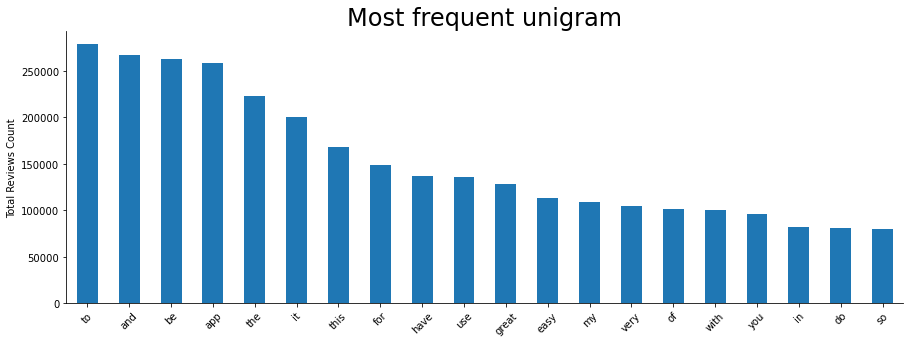

In [95]:
plot_most_frequent(cv_round_3_totals_df, 'unigram')

It appears that the most frequent tokens observed in the text normalized English language reviews are generally stop words, with exceptions, such as `great` and `easy`. Although stop words removal was not specified in the countvectorizer function, more details regarding stop words are described in Part 3. For additional EDA, I will remove the stop words using a default stop words list deployed in the sklearn library and observe the results.

In [96]:
# Instantiate Countvectorizer with ngrams = 1 and stop words removed
cv_round_3 = CountVectorizer(stop_words='english')

# Fit and transform the review text column
cv_round_3_results = cv_round_3.fit_transform(reviews_df_clean_3_en['review_text'])

In [97]:
cv_round_3_results

<427298x77066 sparse matrix of type '<class 'numpy.int64'>'
	with 5785136 stored elements in Compressed Sparse Row format>

With the stop words default removal implemented, $\approx$ 300 unique tokens were removed (77362 - 77,066). Let's now convert it into a dataframe and plot the top 20 most frequent tokens.

In [98]:
# Create a numpy array of the frequency count of presence for each token
# across the reviews
counts = np.array(cv_round_3_results.astype(bool).sum(axis=0))

# Create a dataframe using the counts and feature/words from the vectorizer
cv_round_3_totals_df = (pd.DataFrame({"count": counts[0]}, index=cv_round_3.get_feature_names()))

In [99]:
cv_round_3_totals_df.describe()

,count
count,77066.000000
mean,75.067293
std,1589.817244
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,258086.000000


With stop words removed, it appears that on average, each token appears in $\approx$ 75 reviews, with a standard deviation of 1,589 reviews. The median value frequency is still 1 review. Outliers are still present in the dataset, with a token present in $\approx$ 258,000 reviews.

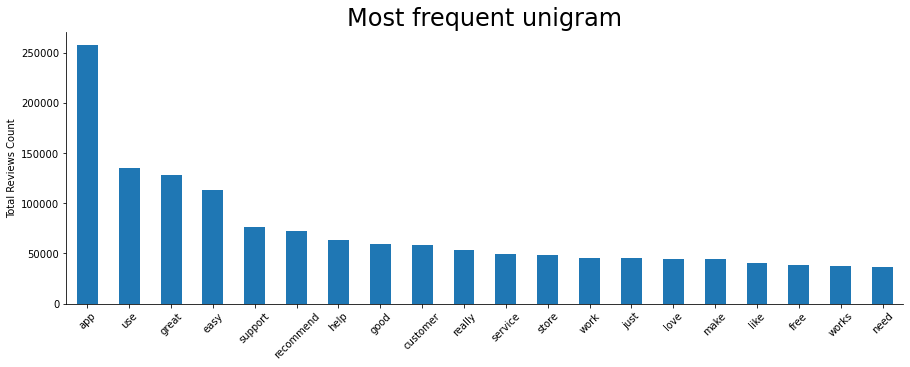

In [100]:
plot_most_frequent(cv_round_3_totals_df, 'unigram')

It appears that `app` is the most common token. However, it does not provide much meaning and distinction to why a review may be positive or negative. As a result, it can be a word added to a custom stop words list in future analyses. Interestingly, terms such as `use`, `great`, `easy`, `support` `recommend`, `help`, `good` and `customer` are among the top 10 most frequent tokens. This may indicate the importance of receiving `help` or `support` or possibly `customer support` that reviews are based on. Furthermore, positive sentiment words such as `great` and `good` are in alignment with the observation that the majority of reviews are positively rated. 

Exploratory analysis of bigrams will be conducted in the next section. Further analyses conducted in Parts 3 and 4 will also implement bigrams and possibly trigrams to preserve sequences of words and improve understanding of common characteristics for positive and negative reviews.

## What is the 20 most common bigrams throughout the reviews?

I will now evaluate what the most common bigrams are throughout the reviews.

In [101]:
# Instantiate Countvectorizer with ngrams = 2 and stop words removed
cv_round_3_bigrams = CountVectorizer(stop_words='english', ngram_range=(2,2))

# Fit and transform the review text column
cv_round_3_bigrams_results = cv_round_3_bigrams.fit_transform(reviews_df_clean_3_en['review_text'])

In [102]:
cv_round_3_bigrams_results

<427298x1387612 sparse matrix of type '<class 'numpy.int64'>'
	with 5902857 stored elements in Compressed Sparse Row format>

The number of unique features for only bigrams specified resulted in $\approx$ 1.4 million tokens.

In [103]:
# Create a numpy array of the frequency count of presence for each token
# across the reviews
counts = np.array(cv_round_3_bigrams_results.astype(bool).sum(axis=0))

# Create a dataframe using the counts and feature/words from the vectorizer
cv_round_3_bigrams_totals_df = (pd.DataFrame({"count": counts[0]}, index=cv_round_3_bigrams.get_feature_names()))

In [104]:
# Suppress scientific notation output
pd.set_option('display.float_format', lambda x: '%.3f' % x)

cv_round_3_bigrams_totals_df.describe()

,count
count,1387612.000
mean,4.254
std,93.014
min,1.000
25%,1.000
50%,1.000
75%,2.000
max,50336.000


With stop words removed and only bigrams extracted, it appears that on average, each bigram appears in $\approx$ 4 reviews, with a standard deviation of 93 reviews. The median value frequency is still 1 review. The highest frequency of appearance for a bigram $\approx$ 50,000 reviews.

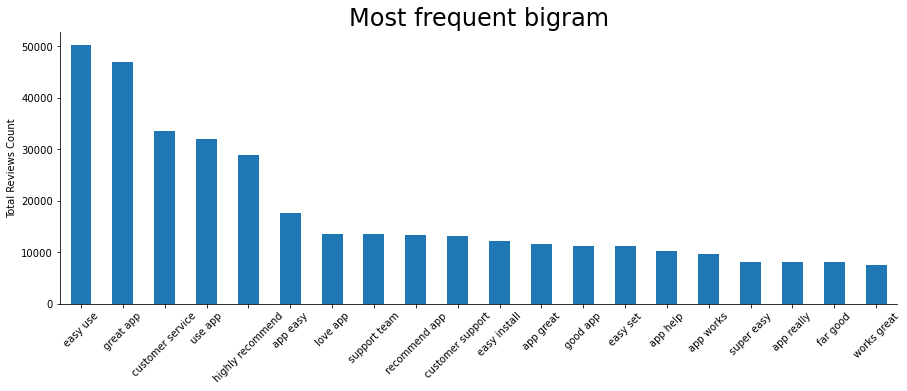

In [105]:
plot_most_frequent(cv_round_3_bigrams_totals_df, 'bigram')

It appears that `easy use` is the most common token. A related bigram is `super easy` and `easy set`. These bigrams indicate the importance to users/merchents about an app's usability. Furthermore, bigrams such as `highly recommend`, `app easy`, `love app`, `app great`, `good app`, `app works`, and `works great` contain positive sentiment. 

Furthermore, bigrams such as `customer service`, `support team`, and `customer support` all relate to some form of customer support team or service and is an important potential theme across the reviews and to users/merchants in determining whether an app will be positively or negatively rated.

Lastly, `recommend app` may appear to have positive sentiment. However, without additional words within the sequence to determine whether the preceding words include `not`, it is not clear. This finding supports the case for including trigrams into future analysis.

I will now take a deeper look at the multi-language reviews that were compiled after Round 2 of text pre-processing completed earlier in the notebook.

## What is the distribution of positive and negative multi-language reviews?

In [106]:
reviews_df_clean_2_multi_lingual['is_review_good'].value_counts()

1    18040
0     1300
Name: is_review_good, dtype: int64

In [107]:
round(reviews_df_clean_2_multi_lingual['is_review_good'].value_counts(normalize = True) * 100, 2)

1   93.280
0    6.720
Name: is_review_good, dtype: float64

The ratio of positive and negative reviews were a similar ratio from the overall dataset, with $\approx$ 93.3% of positive reviews and $\approx$ 6.7% of negative reviews.

## How many different languages were detected?

Based on the total count of reviews observed for each unique `language` from `reviews_df_clean_2_multi_lingual`, there are approximately 94 different languages detected from the Kaggle dataset of the Shopify App Store reviews.

In [108]:
# Retrieve total review count for each language
reviews_df_clean_2_multi_lingual['language'].value_counts()

French                     5926
Spanish; Castilian         4738
Portuguese                 4410
German                     1129
Italian                     965
                           ... 
Assamese                      1
Haitian; Haitian Creole       1
Javanese                      1
Sinhala; Sinhalese            1
Ido                           1
Name: language, Length: 94, dtype: int64

However, we see at the very end of the series of the total reviews count for each language, some of these languages only contained 1 review. Due to the potential false-positives or misclassification of some of the reviews by the pre-trained model for a particular language and/or due to the review text containing 'noise', an arbitrary threshold will be used.

Specifically, languages will be deemed present if more than 10 reviews for that language are present.

In [109]:
multi_lang_10_or_more_reviews = reviews_df_clean_2_multi_lingual['language'].value_counts() > 10

In [110]:
multi_lang_10_or_more_reviews.sum()

32

After threshold, we see that there are $\approx$ 32 different languages present with more than 10 reviews. Let's take a look at the names of these languages that are present and their corresponding count.

In [111]:
multi_lang_df = reviews_df_clean_2_multi_lingual['language'].value_counts()[multi_lang_10_or_more_reviews].\
                to_frame().reset_index().rename(columns = {'index':'language', 'language':'total_reviews'})

In [112]:
multi_lang_df.head()

,language,total_reviews
0,French,5926
1,Spanish; Castilian,4738
2,Portuguese,4410
3,German,1129
4,Italian,965


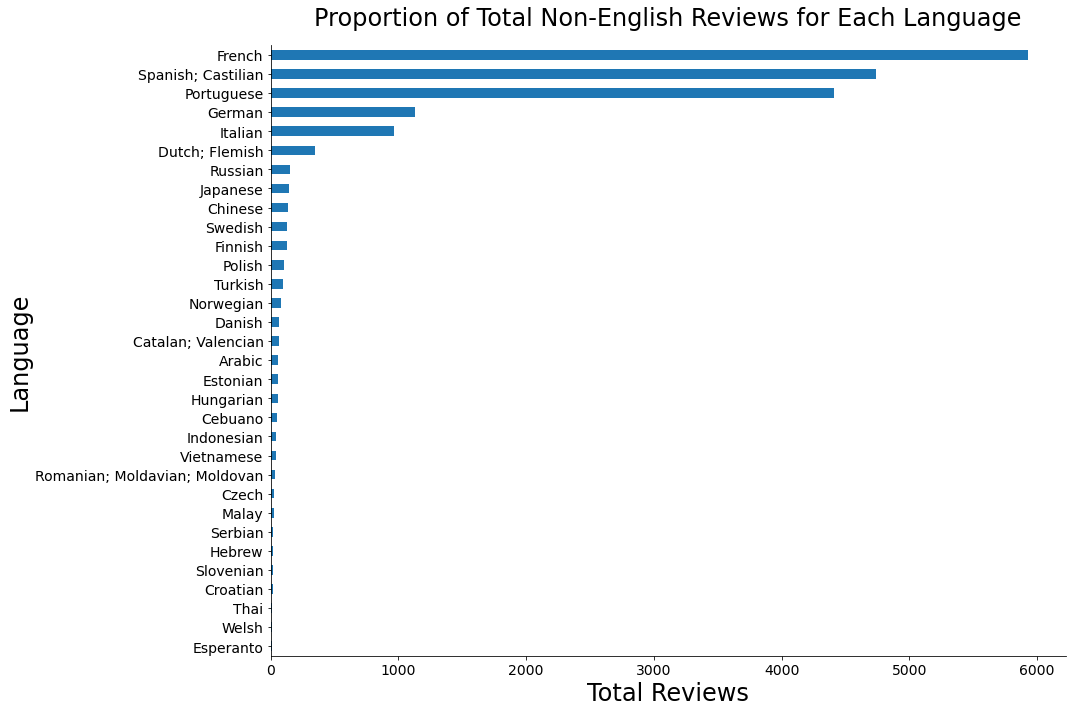

In [113]:
############# Horizontal Bar Graph #############
data = multi_lang_df['total_reviews'].values
df = pd.DataFrame(data,columns=['total_reviews'], index = multi_lang_df['language'])

df.sort_values(by = 'total_reviews', ascending = True).plot.barh(figsize = (15,10), legend=None)

# Set title and labels for axes
plt.ylabel("Language", size=24)
plt.xlabel("Total Reviews", size=24)
plt.title("Proportion of Total Non-English Reviews for Each Language",
          size=24,
          pad=20)

# Set axes ticks
plt.xticks(size = 14)
plt.yticks(size = 14)

# Remove top and right borders
sns.despine()
    
plt.tight_layout()
plt.show()

A wide-range of languages can be observed in this dataset. With the exception of English the top 10 languages with the most reviews include:

- French (30.6% of total multi-language reviews)
- Spanish; Castilian  (24.5%)
- Portuguese (22.8%)
- German (5.8%)
- Italian (5.0%)
- Dutch; Flemish (1.8%)
- Russian (0.8%)
- Japanese (0.7%)
- Chinese (0.7%)
- Swedish (0.6%)

## What is the total multi-language reviews observed over the years?

In [114]:
reviews_df_clean_2_multi_lingual[reviews_df_clean_2_multi_lingual['dev_reply_text'].notna()]

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso,language
19,Sticky Add To Cart BOOSTER PRO,2019-12-27,excelente ayuda a que la compra no se vaya de ...,Hola Amatista Electronik! ¡Muchas gracias por ...,2019-12-28,1,es,Spanish; Castilian
20,Sticky Add To Cart BOOSTER PRO,2019-11-24,jai vu votre appli sur certains sites et sans ...,"Bonjour BeTech 4 Life ™, merci pour votre avis :)",2019-11-28,1,fr,French
21,Sticky Add To Cart BOOSTER PRO,2019-11-18,bonne application cest dommage quelle soit pay...,"Bonjour Torgaw, nous apprécions la critique :)...",2019-11-18,1,fr,French
22,Sticky Add To Cart BOOSTER PRO,2019-10-17,vraiment satisfait de lapplication le rendu es...,"Bonjour Ultimate Barbe™, merci pour cette bell...",2019-10-19,1,fr,French
23,Sticky Add To Cart BOOSTER PRO,2019-10-16,voy a probar la aplicacion haver si funciona e...,"Hola Smart & Market, gracias por tu comentario...",2019-10-16,1,es,Spanish; Castilian
...,...,...,...,...,...,...,...,...
19276,Affiliatly Affiliate Marketing,2020-05-28,jai téléchargé ce matin votre application jai ...,"Hi,\n​we have a french translation, you can en...",2020-05-28,1,fr,French
19317,Promotion Popup by Secomapp,2018-04-17,assez pratique lappli est simple dutilisation ...,Thanks for your review. If you confuse about a...,2019-07-14,0,fr,French
19322,Image Optimizer,2019-09-15,i love it,Thank you so much for taking the time to leave...,2019-09-15,1,sv,Swedish
19323,Image Optimizer,2019-05-03,muito bom adorei deixou meu sitem muito mais l...,Muito Obrigado! Thank you so much for the grea...,2019-05-04,1,pt,Portuguese


In reviewing some of the developer responses, it is interesting to note that some multi-language reviews appear to contain English language developer responses.

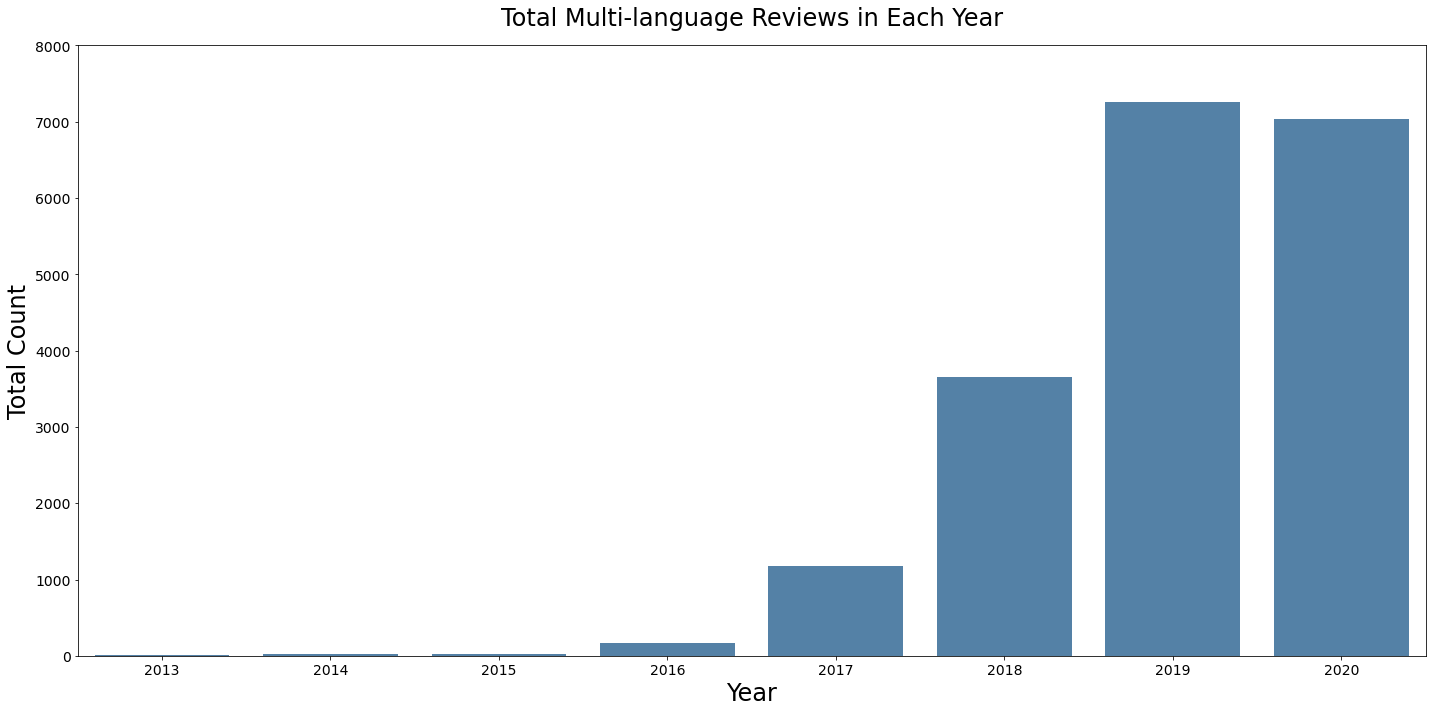

In [115]:
plt.figure(figsize=(20, 10))

############# Bar Graph #############
sns.barplot(x=reviews_df_clean_2_multi_lingual['review_date'].dt.year.value_counts().index,
            y=reviews_df_clean_2_multi_lingual['review_date'].dt.year.value_counts(),
            color='steelblue')

# Set title and labels for axes
plt.xlabel("Year", size=24)
plt.ylabel("Total Count", size=24)
plt.title("Total Multi-language Reviews in Each Year", size=24, pad=20)
plt.yticks(size=14)
plt.xticks(size=14)

# Set axis limits
plt.ylim(0, 8_000)

plt.tight_layout()
plt.show()

## How many non-English language reviews received developer responses in English?

In [116]:
reviews_df_clean_2_multi_lingual.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso,language
0,Instant Search +,2017-01-19,bonne idée cette application intéressante nhés...,NaN,NaT,1,fr,French
1,Instant Search +,2016-07-25,pt por hora estou apaixonada pelo app acabei d...,NaN,NaT,1,pt,Portuguese
2,Sticky Add To Cart BOOSTER PRO,2020-06-27,excelente aplicación doy cinco estrellas por e...,NaN,NaT,1,es,Spanish; Castilian
3,Sticky Add To Cart BOOSTER PRO,2020-06-13,ich finde die app wirklich mega hat wirklich d...,NaN,NaT,1,de,German
4,Sticky Add To Cart BOOSTER PRO,2020-05-21,ainda testando mas era realmente o que eu esta...,NaN,NaT,1,pt,Portuguese


In [117]:
# Create a copy of the reviews_df_clean_2_multi_lingual dataframe and name it
# all_dev_responses
all_dev_responses = reviews_df_clean_2_multi_lingual.copy()

In [118]:
# Retrieve only developer responses that are not missing
all_dev_responses = all_dev_responses[all_dev_responses['dev_reply_text'].notna()]

In [119]:
all_dev_responses.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso,language
19,Sticky Add To Cart BOOSTER PRO,2019-12-27,excelente ayuda a que la compra no se vaya de ...,Hola Amatista Electronik! ¡Muchas gracias por ...,2019-12-28,1,es,Spanish; Castilian
20,Sticky Add To Cart BOOSTER PRO,2019-11-24,jai vu votre appli sur certains sites et sans ...,"Bonjour BeTech 4 Life ™, merci pour votre avis :)",2019-11-28,1,fr,French
21,Sticky Add To Cart BOOSTER PRO,2019-11-18,bonne application cest dommage quelle soit pay...,"Bonjour Torgaw, nous apprécions la critique :)...",2019-11-18,1,fr,French
22,Sticky Add To Cart BOOSTER PRO,2019-10-17,vraiment satisfait de lapplication le rendu es...,"Bonjour Ultimate Barbe™, merci pour cette bell...",2019-10-19,1,fr,French
23,Sticky Add To Cart BOOSTER PRO,2019-10-16,voy a probar la aplicacion haver si funciona e...,"Hola Smart & Market, gracias por tu comentario...",2019-10-16,1,es,Spanish; Castilian


In [120]:
# Apply the basic text pre-processing, which is removing the code for line breaks
# This is necessary for being able to pass the data through the pre-trained 
# language detection classifier
all_dev_responses['dev_reply_text'] = all_dev_responses['dev_reply_text'].progress_apply(lambda x: clean_review_round_1(x))

100%|██████████| 2213/2213 [00:00<00:00, 184430.03it/s]


In [121]:
# Apply the language detection model that was previously defined
all_dev_responses['dev_lang_iso'] = all_dev_responses['dev_reply_text'].progress_apply(lambda x: lang_detect(x))

100%|██████████| 2213/2213 [00:00<00:00, 18749.31it/s]


In [122]:
# Express the proportion of developer response languages as percentage of
# total developer responses observed for only non-english language reviews
round(all_dev_responses['dev_lang_iso'].value_counts(normalize = True), 3) * 100

en   63.500
fr   12.500
es   10.000
pt    4.800
de    4.100
it    2.500
ja    0.500
nl    0.400
ru    0.400
et    0.200
he    0.200
zh    0.200
vi    0.100
hu    0.100
id    0.100
cs    0.100
ro    0.100
sl    0.000
ar    0.000
tr    0.000
sr    0.000
ta    0.000
no    0.000
Name: dev_lang_iso, dtype: float64

In [123]:
# Look at all the developer responses that responded in the English language
# and compare that with the language that the review was written in
all_dev_responses[all_dev_responses['dev_lang_iso'] == 'en']

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso,language,dev_lang_iso
24,Sticky Add To Cart BOOSTER PRO,2019-10-11,asdasdasdasdasdasdasdklidashoiasdhodhasoldnaso...,"Hi Azmita, thank you for your review 🙏! Happy ...",2019-10-13,1,de,German,en
27,Sticky Add To Cart BOOSTER PRO,2019-09-21,nicee,"Hi Woman Body Shape, thank you for your review...",2019-09-25,1,nl,Dutch; Flemish,en
36,Sticky Add To Cart BOOSTER PRO,2019-07-18,nicee,Thank you for your review!! :) 🙏 🤩,2019-07-19,1,nl,Dutch; Flemish,en
78,FAQ Accordion | Help Center,2020-07-29,aplicativo diz ter plano gratuito e é verdade ...,"Hi there, So sorry if the free features you ca...",2020-08-25,0,pt,Portuguese,en
79,FAQ Accordion | Help Center,2020-05-18,péssimo péssimo péssimo perca de tempo horríve...,"Hi there, Thanks for writing in and so sorry f...",2020-05-19,0,pt,Portuguese,en
...,...,...,...,...,...,...,...,...,...
19276,Affiliatly Affiliate Marketing,2020-05-28,jai téléchargé ce matin votre application jai ...,"Hi, ​we have a french translation, you can ena...",2020-05-28,1,fr,French,en
19317,Promotion Popup by Secomapp,2018-04-17,assez pratique lappli est simple dutilisation ...,Thanks for your review. If you confuse about a...,2019-07-14,0,fr,French,en
19322,Image Optimizer,2019-09-15,i love it,Thank you so much for taking the time to leave...,2019-09-15,1,sv,Swedish,en
19323,Image Optimizer,2019-05-03,muito bom adorei deixou meu sitem muito mais l...,Muito Obrigado! Thank you so much for the grea...,2019-05-04,1,pt,Portuguese,en


Although some of the classified multi-language reviews were actually in English, it is interesting to see that $\approx$ 64% of developer responses to non-English language reviews were written in English. This finding indicates a potential language barrier that exists within the Shopify App Store when it comes to interacting with users/merchants and possible challenges for receiving assistance, if any.

# Summary

Through various rounds of text pre-processing followed by separating out English language reviews from non-English reviews, dimensionality reduction was achieved through reducing the size of the vocabulary or unique tokens observed across the corpus of reviews from $\approx$ 104,000 to $\approx$ 77,000 - 81,000.

Among the top 10 most frequently observed tokens in the reviews, terms related to `customer support`, `support` or `help` may foreshadow an important theme across the reviews. Unigrams with generally positive sentiment, such as `good`, `great`, `easy`, were among the most frequent words and may be a result of $\approx$ 93% of reviews being positively rated. 

By implementing bigrams to be extracted from the reviews, of the top 20 bigrams, `easy use` was the most common token. This may indicate the importance to users/merchents about an app's usability. Furthermore, bigrams such as `customer service`, `support team`, and `customer support` indicate the importance of customer support received from app developers. Many positive sentiments were observed within the bigrams, such as `highly recommend` or `good app`. Although, `recommend app` may appear to have positive sentiment, it is unclear whether preceding words include `not`, which would change the sentiment completely. This finding supports the case for including trigrams into future analysis to improve the understanding for characteristics that relate to positive and negative reviews. 

As an immediate actionable insight, these frequent bigrams may be beneficial to the user community to quickly gauge the overall sentiment of an app before choosing to install or use it. Integrating the top 5 most positive and/or negative bigrams observed for all the reviews for a particular app within the app store may facilitate easier decision making.

There was about 94 different languages observed throughout the multi-language reviews. To account for potential language misclassification, an arbitrary threshold was used and it was determined that 32 languages were present (based on observing more than 10 reviews for a particular language). In observing the multi-language or non-English language review, $\approx$ 64% of developer responses to those reviews were completed in the English language. This finding may indicate a potential language barrier for users/merchants that authored non-English language reviews seeking support or guidance but receiving responses not in their native language. Further analysis is warranted to identify the strength of the support being provided to non-English merchants within the Shopify App store ecosystem.

In adopting the data-centric mindset, further optimization of the text-preprocessing with custom stop words list can be used, followed by iterative text normalization.

Future analyses can integrate Textblob or VADER for sentiment analysis with values between -1 and +1 and create a scatterplot with respect to polarity of positive and negative reviews or observe how it changes over time. Furthermore, a tSNE plot may be another option for visualizing positive and negative reviews for determining how separate or not the reviews are and whether the class imbalance needs to be addressed with various sampling techniques.